# Solar Panel Power Prediction 

## Problem Identification 

I have chosen the Solar Panel Generation data set from kaggle to get a better understanding of how solar panels work. Ive felt for a long time that green energy is what the future holds in terms or renewable energy sources and wanted to delve in to what and how they tick. My goal with the data set is to get an understanding of how weather and other environental features affect the solar panel power generation. Possibly get an inside look at how the solar plant tries to produce energy when there is cloud coverage and or winter when there reduced sun. With that being said, I plan on forecasting where or not the solar panels are affected when solar irradiation is high. I will do this by trying to predict the total yield day to day using ensemble models to optimize the daily yield. Through this techinque i will be able to ascertain if the weather was clear and or cloud/ rainy by the production power harnessed in that row and or day. From there I would recommend to the solar plant management a course of action to fix certain panels, possibly try and angle them a different direction or clean them depending upon the data that is in the set. 

## Data Gathering 

I have found an interesting data set from kaggle that includes three secondary sets that complement the first power Generation set that the algo will try and optimize. 

The Primary Data set includes 

- Plant_ID
- Source_key
- DC_POWER
- AC_POWER 
- DAILY_YIELD
- TOTAL_YIELD

The secondary set 1 that supplements the primary source is the Weather sensing source data set.

This secondary set includes 

- Plant_ID
- Source_key
- Ambient_Temperature 
- Module_Temperature
- Irradiation 

Lastly the last two data sets are two correlating sets of both power generation and weather sensing data for the second plant. 


Ive attached the Dataset link here to help find the dataset. 

https://www.kaggle.com/anikannal/solar-power-generation-data


## Downloading Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

Reading in the dataset from the Kaggle downloaded zipfile

In [5]:
# read in data
powerGeneration = pd.read_csv("/Users/Kasden/Desktop/MSFERM3/brianlois/FinalProject/Archive/Plant_1_Generation_Data.csv",parse_dates=['DATE_TIME'],index_col=0)

## Feature Engineering

The Dataset originally didnt include alot of feature columns, but the information provided is fully encompassing of the problem stated before. I found that some features should be included such as the day, month, and hour whereas the data set was in the time frame of a month total. These features allowed for a better representation of time series data then the 15s increments that were occuring throughout the day. By the addition of Month, day, and hour this can give us a more grand scheme overlook of whats occuring thoroughout the day on a higher time frame. Secondly from the raw data I found that the DC power to Ac power was having a massive drop of from energy direcly collected to the power actually converted and ready for power use.

In [6]:
# Feature addition to the Power generatation set from raw data
def add_feature(powerGeneration):
    powerGeneration['DATE_TIME']=powerGeneration.index.year
    powerGeneration['month']=powerGeneration.index.month
    powerGeneration['day']=powerGeneration.index.day
    powerGeneration['hour']=powerGeneration.index.hour
    powerGeneration['PowerLoss DC - AC']= (powerGeneration['DC_POWER'] - powerGeneration['AC_POWER'])/powerGeneration['DC_POWER']
    powerGeneration['AC to Yield loss'] =  powerGeneration['AC_POWER'] - powerGeneration['DAILY_YIELD']
    
    
add_feature(powerGeneration)

Addition of features not included in the first set, this includes data from a second plant with the addition of the features added to the set above are also added to the plant below. Secondly the weather report on both of the plants is being added to cross check daily yield output against the irradiation found by the weather sensors that is a result of cloud cover. These times of irradiation show when the clouds are covering at a certain instant in time or whether its raining. 
The weather sensing sets included the ambient and module temperatures which detail the area temperature(ambient) and the temp of the device(module). From here I created the delta of the two finding the difference called TEMPERATURE DIFFERENCE. 

In [7]:
# addition of outsider data from the original plant data set 
# bringing in the weather for the area, bringing in a plant from a different location and the weather assciated with 
weatherSensing = pd.read_csv("/Users/Kasden/Desktop/MSFERM3/brianlois/FinalProject/Archive/Plant_1_Weather_Sensor_Data.csv",parse_dates=['DATE_TIME'],index_col=0)
powerGeneration2 = pd.read_csv("/Users/Kasden/Desktop/MSFERM3/brianlois/FinalProject/Archive/Plant_2_Generation_Data.csv",parse_dates=['DATE_TIME'],index_col=0)
weatherSensing2 = pd.read_csv("/Users/Kasden/Desktop/MSFERM3/brianlois/FinalProject/Archive/Plant_2_Weather_Sensor_Data.csv",parse_dates=['DATE_TIME'],index_col=0)

def add_feature2(powerGeneration2):
    powerGeneration2['DATE_TIME']=powerGeneration2.index.year
    powerGeneration2['month']=powerGeneration2.index.month
    powerGeneration2['day']=powerGeneration2.index.day
    powerGeneration2['hour']=powerGeneration2.index.hour
    powerGeneration2['PowerLoss DC - AC']= (powerGeneration2['DC_POWER'] - powerGeneration2['AC_POWER'])/powerGeneration2['DC_POWER']
    powerGeneration2['AC to Yield loss'] =  powerGeneration2['AC_POWER'] - powerGeneration2['DAILY_YIELD']
add_feature2(powerGeneration2)

def add_feature3(weatherSensing):
    weatherSensing['TEMPERATURE DIFFERENCE'] = weatherSensing['AMBIENT_TEMPERATURE'] - weatherSensing['MODULE_TEMPERATURE']
    weatherSensing['DATE_TIME']=weatherSensing.index.year
    weatherSensing['month']=weatherSensing.index.month
    weatherSensing['day']=weatherSensing.index.day
    weatherSensing['hour']=weatherSensing.index.hour
add_feature3(weatherSensing)

def add_feature4(weatherSensing2):
    weatherSensing2['TEMPERATURE DIFFERENCE'] = weatherSensing2['AMBIENT_TEMPERATURE'] - weatherSensing2['MODULE_TEMPERATURE']
    weatherSensing2['DATE_TIME']=weatherSensing2.index.year
    weatherSensing2['month']=weatherSensing2.index.month
    weatherSensing2['day']=weatherSensing2.index.day
    weatherSensing2['hour']=weatherSensing2.index.hour
add_feature4(weatherSensing2)




## Exploratory Anaylsis / Insight Generation

In [12]:
# getting summary statistics of the dataset 
powerGeneration.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68778 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 12 columns):
PLANT_ID             68778 non-null int64
SOURCE_KEY           68778 non-null object
DC_POWER             68778 non-null float64
AC_POWER             68778 non-null float64
DAILY_YIELD          68778 non-null float64
TOTAL_YIELD          68778 non-null float64
DATE_TIME            68778 non-null int64
month                68778 non-null int64
day                  68778 non-null int64
hour                 68778 non-null int64
PowerLoss DC - AC    36827 non-null float64
AC to Yield loss     68778 non-null float64
dtypes: float64(6), int64(5), object(1)
memory usage: 6.8+ MB


In [13]:
# getting an idea of what the data looks like at the head
powerGeneration.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,month,day,hour,PowerLoss DC - AC,AC to Yield loss
DATE_TIME,,,,,,,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,2020,5,15,0,NaN,0.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,2020,5,15,0,NaN,0.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,2020,5,15,0,NaN,0.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,2020,5,15,0,NaN,0.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,2020,5,15,0,NaN,0.0


In [14]:
# getting an idea of what the data looks like at the tail
powerGeneration.tail()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,month,day,hour,PowerLoss DC - AC,AC to Yield loss
DATE_TIME,,,,,,,,,,,,
2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,2020,6,17,23,NaN,-5967.000
2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,2020,6,17,23,NaN,-5147.625
2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,2020,6,17,23,NaN,-5819.000
2020-06-17 23:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,2020,6,17,23,NaN,-5817.000
2020-06-17 23:45:00,4135001,zVJPv84UY57bAof,0.0,0.0,5910.000,7363272.0,2020,6,17,23,NaN,-5910.000


Using the describe feature, we can get a feature distribution of the data which includes the max, min, standard deviation for the data and the mean.

From early comparing upon the two data sets, I observed that the power loss in plant 1 to plant 2 was extremely different. This led me to believe that both of these plants must be in different locations and or possibly that the plant one is older and dealing with some dust issue. 

I looked into if it was a dusty country and the answer is yes, the country is dealing with a dust pollution problem due to the deforestation and hence wind erosion, uncontrolled industrial particle emission, Leaving land untreated. all of which can directly affect whats going on at plant one. With that being said the Daily yield between the two locations is relatively similar. 
Plant 2 seems to only take in the energy it needs to produce AC from the DC at an almost 1:1 ratio. 

In [15]:
# getting summary stats on the distribution of the data 
powerGeneration.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,month,day,hour,PowerLoss DC - AC,AC to Yield loss
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04,68778.0,68778.000000,68778.000000,68778.000000,36827.000000,68778.000000
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06,2020.0,5.707203,15.573497,11.567216,0.902281,-2988.165985
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05,0.0,2.206167,8.506467,6.862477,0.000458,3137.463961
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06,2020.0,1.000000,6.000000,0.000000,0.893408,-9163.000000
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06,2020.0,5.000000,6.000000,6.000000,0.901986,-5987.000000
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06,2020.0,5.000000,16.000000,12.000000,0.902155,-1679.657143
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06,2020.0,6.000000,23.000000,17.000000,0.902421,0.000000
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06,2020.0,12.000000,31.000000,23.000000,0.904448,414.762500


In [16]:
powerGeneration2.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE_TIME,month,day,hour,PowerLoss DC - AC,AC to Yield loss
count,67698.0,67698.000000,67698.000000,67698.000000,6.769800e+04,67698.0,67698.000000,67698.000000,67698.000000,32036.000000,67698.000000
mean,4136001.0,246.701961,241.277825,3294.890295,6.589448e+08,2020.0,5.529705,15.530680,11.530208,0.023194,-3053.612470
std,0.0,370.569597,362.112118,2919.448386,7.296678e+08,0.0,0.499120,8.527546,6.922127,0.005020,2939.880563
min,4136001.0,0.000000,0.000000,0.000000,0.000000e+00,2020.0,5.000000,1.000000,0.000000,-0.008320,-9873.000000
25%,4136001.0,0.000000,0.000000,272.750000,1.996494e+07,2020.0,5.000000,9.000000,6.000000,0.019753,-5295.543571
50%,4136001.0,0.000000,0.000000,2911.000000,2.826276e+08,2020.0,6.000000,16.000000,12.000000,0.021568,-2527.543333
75%,4136001.0,446.591667,438.215000,5534.000000,1.348495e+09,2020.0,6.000000,22.000000,18.000000,0.024986,0.000000
max,4136001.0,1420.933333,1385.420000,9873.000000,2.247916e+09,2020.0,6.000000,31.000000,23.000000,0.087210,506.100000


The data was fairly clean, all the data point were accounted for and wasnt missing. From the table presented below I do have a large total for powerloss not being zero which actually yielded a NAN for the column value. This wasnt a problem as the solar sites arent always generating power which causes 0/0 which fueled the nan from my created feature list.

In [8]:
# Data checking to see if all the values are accounted for, 0 is a valid value for power generation and Temperature
print(powerGeneration.isna().sum())
print(powerGeneration2.isna().sum())
print(weatherSensing.isna().sum())
print(weatherSensing2.isna().sum())


PLANT_ID                 0
SOURCE_KEY               0
DC_POWER                 0
AC_POWER                 0
DAILY_YIELD              0
TOTAL_YIELD              0
DATE_TIME                0
month                    0
day                      0
hour                     0
PowerLoss DC - AC    31951
AC to Yield loss         0
dtype: int64
PLANT_ID                 0
SOURCE_KEY               0
DC_POWER                 0
AC_POWER                 0
DAILY_YIELD              0
TOTAL_YIELD              0
DATE_TIME                0
month                    0
day                      0
hour                     0
PowerLoss DC - AC    35662
AC to Yield loss         0
dtype: int64
PLANT_ID                  0
SOURCE_KEY                0
AMBIENT_TEMPERATURE       0
MODULE_TEMPERATURE        0
IRRADIATION               0
TEMPERATURE DIFFERENCE    0
DATE_TIME                 0
month                     0
day                       0
hour                      0
dtype: int64
PLANT_ID                  0
SOURC

Getting a look at the correlation plots of both of the weather sensor sources to see if i can find preliminary panels(Source_Keys) that are the module locations producing the electricity. 

The two correlation plots further affirm, that the two locations are not near each other and are in two different parts of the country. 

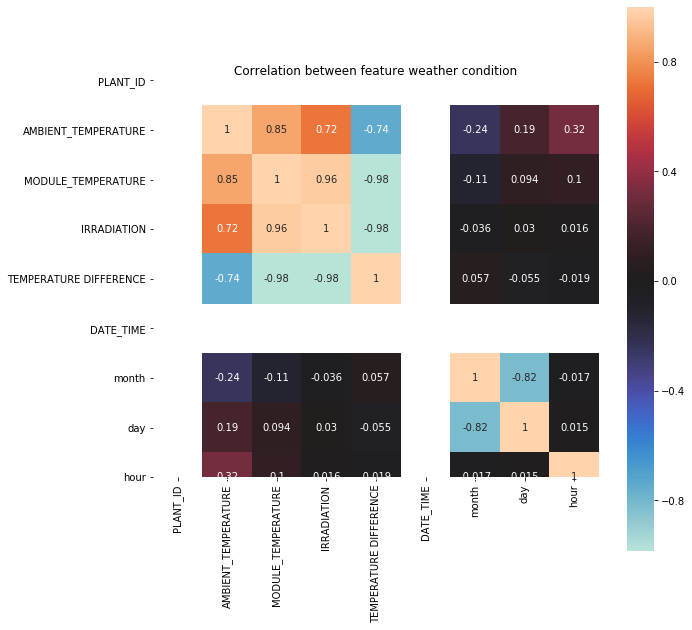

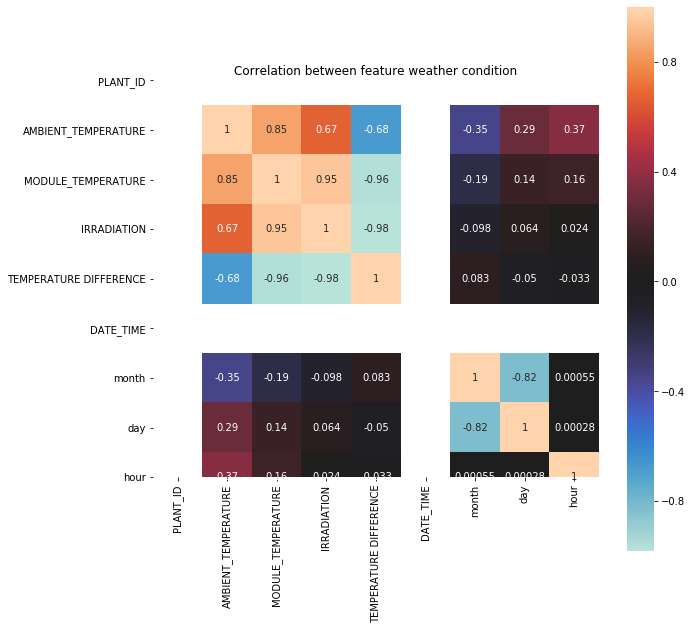

In [18]:
# correlation plots for weather 
plt.figure(figsize=(10,10))
sns.heatmap(weatherSensing.corr(), annot=True, center=0, square=True)
plt.title('Weather Correlation Plant 1')
plt.show()

plt.figure(figsize=(10,10))
sns.heatmap(weatherSensing2.corr(), annot=True, center=0, square=True)
plt.title('Weather Correlation Plant 2')
plt.show()

Upon testing the trends overtime, we see that the data set is confined to two months of the year which the data does reside within. Ive broken it down into hourly, weekly and monthly data to see how the total yield production of energy changed throughout the day, week and month. We can immediately see that peek hours of production are around noon when the sun is mostly directly overhead. Looking at the monthly chart we see that the production of power was higher in May then that of June, this is primarily due to the data being cut short within the early month of June.

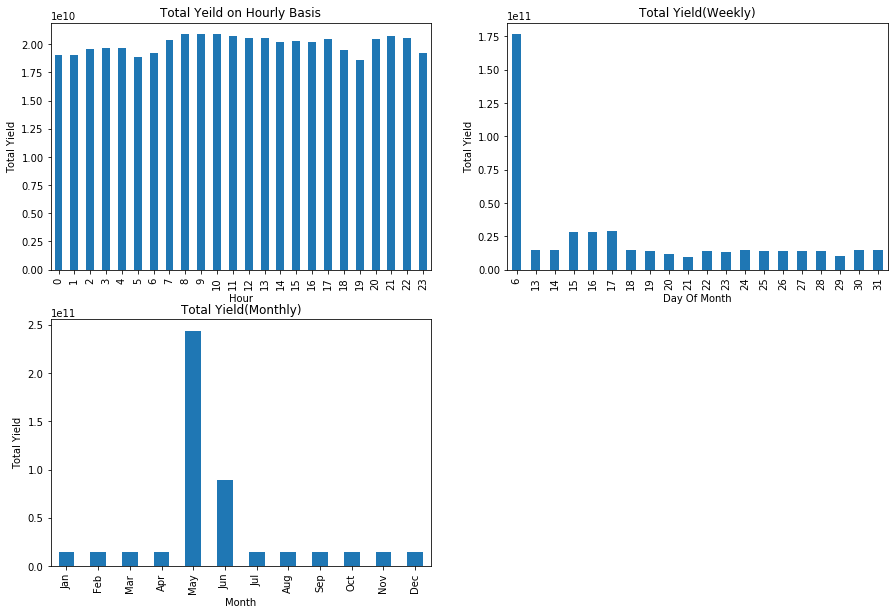

In [20]:
'''
Distribution over time
'''
# Yield output plots based on hour, day and month var

plt.figure(figsize=(15,10))
plt.subplot(2,2,1,)
powerGeneration.groupby('hour')['TOTAL_YIELD'].sum().plot.bar()
plt.title('Total Yeild on Hourly Basis')
plt.xlabel('Hour')
plt.ylabel('Total Yield')

plt.subplot(2,2,2,)
powerGeneration.groupby('day')['TOTAL_YIELD'].sum().plot.bar()
plt.title('Total Yield(Weekly)')
plt.xlabel('Day Of Month')
plt.ylabel('Total Yield')

plt.subplot(2,2,3,)
ax1=powerGeneration.groupby('month')['TOTAL_YIELD'].sum().plot.bar()
plt.title('Total Yield(Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Yield')
ax1.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))

plt.show()


Here we are comparing the power outputs of both plants by the inverter production of both of the plants. Earlier it was noted that these two plants werent in the same location and its further proven here. Here we see that the inverters for plant 1 were losing about 90 percent power from the conversion from DC_Power to AC_Power. While for plant 2 we see that the data shows a more 1:1 ratio as it was noted before. 
This further leads me to believe that either both plants are utilizing different setups of panels yet they both produce a very closely related total yield of power.

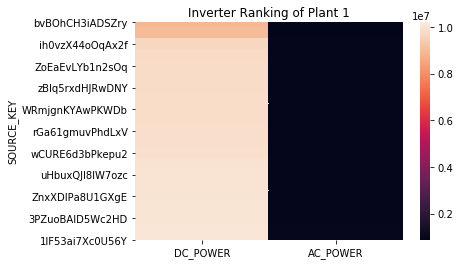

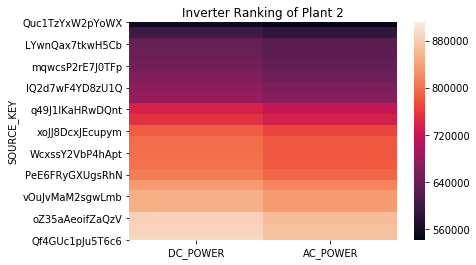

In [22]:
# output of power 

InverterHO1 = powerGeneration.groupby('SOURCE_KEY')[['DC_POWER', 'AC_POWER']].agg('sum').sort_values(by='DC_POWER')
InverterHO2 = powerGeneration2.groupby('SOURCE_KEY')[['DC_POWER', 'AC_POWER']].agg('sum').sort_values(by='DC_POWER')


# see if a specific inverter on either plant is the most or least amount of produciton 
sns.heatmap(InverterHO1)
plt.title('Inverter Ranking of Plant 1')
plt.show()

sns.heatmap(InverterHO2)
plt.title('Inverter Ranking of Plant 2')
plt.show()

Finding the amount of unique source_key panels to see how many panels there are for each location.

In [19]:
#preliminary check to see if the 22 source invertes that the data set returned are acutally linearly producing data like the other adjacent panes are, checking for inconsistencies among panels 
print('\nUnique values :  \n',powerGeneration.nunique())
print('\nUnique values :  \n',powerGeneration2.nunique())

InverterList= powerGeneration['SOURCE_KEY'].unique()
InverterList

InverterList2 = powerGeneration2['SOURCE_KEY'].unique()
InverterList2


Unique values :  
 PLANT_ID                 1
SOURCE_KEY              22
DC_POWER             32909
AC_POWER             32686
DAILY_YIELD          29900
TOTAL_YIELD          37267
DATE_TIME                1
month                   12
day                     20
hour                    24
PowerLoss DC - AC    36148
AC to Yield loss     37067
dtype: int64

Unique values :  
 PLANT_ID                 1
SOURCE_KEY              22
DC_POWER             30743
AC_POWER             30721
DAILY_YIELD          30345
TOTAL_YIELD          33114
DATE_TIME                1
month                    2
day                     31
hour                    24
PowerLoss DC - AC    31903
AC to Yield loss     33633
dtype: int64


array(['4UPUqMRk7TRMgml', '81aHJ1q11NBPMrL', '9kRcWv60rDACzjR',
       'Et9kgGMDl729KT4', 'IQ2d7wF4YD8zU1Q', 'LYwnQax7tkwH5Cb',
       'LlT2YUhhzqhg5Sw', 'Mx2yZCDsyf6DPfv', 'NgDl19wMapZy17u',
       'PeE6FRyGXUgsRhN', 'Qf4GUc1pJu5T6c6', 'Quc1TzYxW2pYoWX',
       'V94E5Ben1TlhnDV', 'WcxssY2VbP4hApt', 'mqwcsP2rE7J0TFp',
       'oZ35aAeoifZaQzV', 'oZZkBaNadn6DNKz', 'q49J1IKaHRwDQnt',
       'rrq4fwE8jgrTyWY', 'vOuJvMaM2sgwLmb', 'xMbIugepa2P7lBB',
       'xoJJ8DcxJEcupym'], dtype=object)

## Preprocessing 
 Creating some more features for the x variables portion for the test and train set.

In [9]:
powerGeneration['quarter'] = powerGeneration.index.quarter
powerGeneration['month'] = powerGeneration.index.month
powerGeneration['year'] = powerGeneration.index.year
powerGeneration['dayofyear'] = powerGeneration.index.dayofyear
powerGeneration['dayofmonth'] = powerGeneration.index.day

Using the label encoder from the preprocessing packages above to encoded the Unique source_key from the 22 letter string to an int from 0-21. Kind of like one hot encoding but just another method of usage. Went ahead and used it for the plant id as well for when they are merged in the future. 

In [10]:
label_encoder = preprocessing.LabelEncoder() 
powerGeneration['SOURCE_KEY']= label_encoder.fit_transform(powerGeneration['SOURCE_KEY']) 
powerGeneration['PLANT_ID']= label_encoder.fit_transform(powerGeneration['PLANT_ID']) 

Visual check that the source_key was properly encoded and replicated for the whole of the data.

In [11]:
print(powerGeneration['SOURCE_KEY'])

DATE_TIME
2020-05-15 00:00:00     0
2020-05-15 00:00:00     1
2020-05-15 00:00:00     2
2020-05-15 00:00:00     3
2020-05-15 00:00:00     4
                       ..
2020-06-17 23:45:00    17
2020-06-17 23:45:00    18
2020-06-17 23:45:00    19
2020-06-17 23:45:00    20
2020-06-17 23:45:00    21
Name: SOURCE_KEY, Length: 68778, dtype: int64


Creating the test and train sets for the model implementation. 

Set the Daily yield of the plant to what I would like to be predicting as Y 

Set the Source_Key, quarter, month, dayofmonth, Year, DC_POWER,AC_POWER. Ive selected these from the set as source_key and DC_power correlated with the weather data. When the irradiation was not zero from the weather sensing set, that meant that there was some kind of cloud cover and or rain that was occuring on that day. So with this set we are trying to predict on a random event that rain or cloud did or didnt affect a certain row representation of the data set. 

Each row then would be concluded as a time series in which the model will then interpret as a single event in time based on the conditions interlayed with that row. From this row we would then try and say whether it was clouding or not on that specific row.


Then using the test_train split I can split the data randomly in to a test size of 25 percent based on the original data and 75 percent of data for train



In [12]:
X = powerGeneration[['SOURCE_KEY', 'quarter','month', 'year','dayofmonth','DC_POWER','AC_POWER']]
y = powerGeneration['DAILY_YIELD']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 1)

## Model Testing

For the general Parameters I wanted to test many different tree sizes and creating a nested for loop with the learning rate, my algo can run thru the different tree sizes(boosting stages) apply all the learning rates that take different amounts of time then move to the next one. For the Intial model for the max_ depth I went with 4 as I found this to be a good starting point. The acceptable values range from 3-10 so I stayed near the middle for testing. For random state I left it as zero as I found its not a value that should altered with therefore i left it at zero. It really doesnt carry the weight of the model.

For the loss aspect, its the value that needs to be optimized and the LS is refering to the least squares. Later in the defined model I chose RMSE for the error calculation.



In [13]:
#XGBoost
err = []
predicted = []

for tree in [10, 20, 50, 100, 200]:
    for learnin_rate in [0.01, 0.1, 0.2, 0.5]:
        
        
        est = GradientBoostingRegressor(n_estimators=tree, learning_rate=learnin_rate,max_depth=4, random_state=0, 
                                        loss="ls").fit(X_train, y_train)
        
        vals = est.predict(X_test)
        predicted.append(est.predict(X_test))
        err.append(mean_squared_error(y_test, est.predict(X_test)))

pred_vals = predicted[err.index(min(err))]        

error = []
error.append([pred_vals[i]-np.array(y_test)[i] for i in range(len(np.array(y_test)))])
print("XGBoost", np.mean(error))

XGBoost -12.073632534879744


I wanted to sample many different machine learning algos to see if any were better predictors for modeling what was occuring at the solar plant.

The value found was incredibily low as it should have been. The data is far from linear, the total yield for the plant would eat into the dc power that was being used to create the AC. and further trying to store the electricity and offload it to the surrounding cities diminished the total yield. 
We can see the total yield vary and not move linearly against the selected X and y
Assuming a straight line relationship between the two doesnt suffice in this test

In [28]:
# Linear regression
model = LinearRegression()
model.fit( X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=20)
print("Linear Regression:", model.score(X_test, y_test))

Linear Regression: 0.007603398679030704


Employing a decision tree model was used to try an see if I would receive a classification rate over 50 percent which I didnt recieve with the selected X and y. I feel the Decision tree recieving a value of .30/ 1 accuracy didnt prove strong in predicting the daily yield. I believe that this came from possible overfitting by using the DC and AC _ power in the calculation to find the daily yield instead of just one. Which further leads me to the wondering if thats causing the tree model to create bad attribute choices

Decision Tree: 0.03059195953808269


[Text(113.40592116021423, 215.42666666666668, 'DC_POWER <= 4.375\nmse = 9879151.575\nsamples = 51583\nvalue = 3292.039'),
 Text(7.372211118133579, 211.4, 'dayofmonth <= 25.5\nmse = 12690632.876\nsamples = 23900\nvalue = 2942.797'),
 Text(6.511055707685185, 207.37333333333333, 'dayofmonth <= 22.5\nmse = 12838641.852\nsamples = 20048\nvalue = 3057.985'),
 Text(5.860649193950169, 203.34666666666666, 'dayofmonth <= 21.5\nmse = 12155223.449\nsamples = 17947\nvalue = 2943.883'),
 Text(5.038904822801557, 199.32, 'dayofmonth <= 20.5\nmse = 12205321.124\nsamples = 17261\nvalue = 2990.888'),
 Text(3.682668292578715, 195.29333333333332, 'month <= 6.5\nmse = 12081318.173\nsamples = 16938\nvalue = 2941.7'),
 Text(1.9281435630574004, 191.26666666666665, 'dayofmonth <= 9.5\nmse = 11854597.27\nsamples = 12392\nvalue = 2836.953'),
 Text(0.9466094278161707, 187.24, 'quarter <= 1.5\nmse = 11308423.651\nsamples = 4398\nvalue = 2354.657'),
 Text(0.5295267751529068, 183.21333333333334, 'month <= 2.5\nmse = 

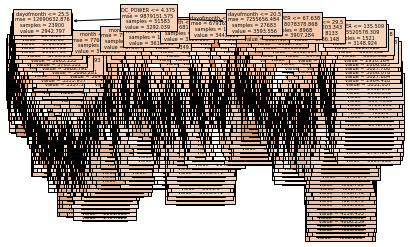

In [34]:
#Decision Tree and plot
dtr = DecisionTreeRegressor(max_depth=None) 
dtr.fit(X_train, y_train)
dtr_scores = cross_val_score(dtr, X_train, y_train, cv=20)
print("Decision Tree:", dtr.score(X_test, y_test))
plot_tree(dtr, filled = True, fontsize = 5, feature_names = X_train.columns)

As with the Decision Tree above the Random forest model is good for regression and classification of multiple decision trees. 
Reported a value of .17

In [30]:
#Random forest

forest_cv = RandomForestRegressor(n_jobs=-1)
forest_cv.fit(X_train,y_train)
print("Random Forest:", forest_cv.score(X_test, y_test))

/Users/Kasden/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest: 0.17118077218471506


From the model above ive decided to go with a learning rate of .05, normally would chose this for speed of the algorithm, but for the terms of this one the learning rate didnt matter in time of process speed as the algo runs pretty quick already. For objective I went with RMSE for the objective or thing thats being optimized.
Col sample by tree was decided as .5 as its the typical range start value 
Min child weight I chose a small value of 5 for leaf node sizes can be a smaller sized group
Max_ depth of 5 as 4-6 as  typical good starting point.
Early stopping rounds is added to try and prevent overfitting 

In [14]:
#XGB regressor defined 
xgbDefined = xgb.XGBRegressor(n_estimators=1000,objective ='reg:squarederror',learning_rate = 0.05, colsample_bytree=0.5,max_depth = 5, min_child_weight = 5)
xgbDefined.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50)


[0]	validation_0-rmse:4430.36	validation_1-rmse:4447.46
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4318.57	validation_1-rmse:4335.57


/Users/Kasden/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2]	validation_0-rmse:4215.1	validation_1-rmse:4231.86
[3]	validation_0-rmse:4119.31	validation_1-rmse:4136.03
[4]	validation_0-rmse:4032.71	validation_1-rmse:4049.55
[5]	validation_0-rmse:3951.12	validation_1-rmse:3967.89
[6]	validation_0-rmse:3872.38	validation_1-rmse:3889.07
[7]	validation_0-rmse:3799.14	validation_1-rmse:3815.87
[8]	validation_0-rmse:3736.95	validation_1-rmse:3753.67
[9]	validation_0-rmse:3675.17	validation_1-rmse:3691.72
[10]	validation_0-rmse:3621.22	validation_1-rmse:3637.57
[11]	validation_0-rmse:3568.37	validation_1-rmse:3584.8
[12]	validation_0-rmse:3523.14	validation_1-rmse:3539.15
[13]	validation_0-rmse:3479.14	validation_1-rmse:3495.02
[14]	validation_0-rmse:3441.83	validation_1-rmse:3457.4
[15]	validation_0-rmse:3406.94	validation_1-rmse:3422.43
[16]	validation_0-rmse:3372.24	validation_1-rmse:3387.9
[17]	validation_0-rmse:3341.07	validation_1-rmse:3356.62
[18]	validation_0-rmse:3315.02	validation_1-rmse:3330.53
[19]	validation_0-rmse:3290.14	validation_1

[146]	validation_0-rmse:2966.95	validation_1-rmse:2994.77
[147]	validation_0-rmse:2966.54	validation_1-rmse:2994.58
[148]	validation_0-rmse:2966.46	validation_1-rmse:2994.59
[149]	validation_0-rmse:2966.26	validation_1-rmse:2994.45
[150]	validation_0-rmse:2966.23	validation_1-rmse:2994.39
[151]	validation_0-rmse:2965.21	validation_1-rmse:2993.64
[152]	validation_0-rmse:2964.9	validation_1-rmse:2993.47
[153]	validation_0-rmse:2964	validation_1-rmse:2992.65
[154]	validation_0-rmse:2963.92	validation_1-rmse:2992.68
[155]	validation_0-rmse:2963.89	validation_1-rmse:2992.68
[156]	validation_0-rmse:2963.34	validation_1-rmse:2992.21
[157]	validation_0-rmse:2963.29	validation_1-rmse:2992.17
[158]	validation_0-rmse:2963.2	validation_1-rmse:2992.12
[159]	validation_0-rmse:2963.07	validation_1-rmse:2992.09
[160]	validation_0-rmse:2962.65	validation_1-rmse:2991.71
[161]	validation_0-rmse:2962.63	validation_1-rmse:2991.7
[162]	validation_0-rmse:2961.74	validation_1-rmse:2990.99
[163]	validation_0-r

[288]	validation_0-rmse:2914.71	validation_1-rmse:2957.58
[289]	validation_0-rmse:2914.37	validation_1-rmse:2957.53
[290]	validation_0-rmse:2914.16	validation_1-rmse:2957.46
[291]	validation_0-rmse:2913.72	validation_1-rmse:2957.08
[292]	validation_0-rmse:2913.7	validation_1-rmse:2957.07
[293]	validation_0-rmse:2913.46	validation_1-rmse:2957.06
[294]	validation_0-rmse:2913.18	validation_1-rmse:2956.85
[295]	validation_0-rmse:2913.15	validation_1-rmse:2956.82
[296]	validation_0-rmse:2913.08	validation_1-rmse:2956.8
[297]	validation_0-rmse:2913.06	validation_1-rmse:2956.82
[298]	validation_0-rmse:2912.67	validation_1-rmse:2956.66
[299]	validation_0-rmse:2912.61	validation_1-rmse:2956.65
[300]	validation_0-rmse:2912.49	validation_1-rmse:2956.56
[301]	validation_0-rmse:2912.4	validation_1-rmse:2956.56
[302]	validation_0-rmse:2911.86	validation_1-rmse:2956.07
[303]	validation_0-rmse:2911.77	validation_1-rmse:2955.98
[304]	validation_0-rmse:2911.61	validation_1-rmse:2955.97
[305]	validation_

[430]	validation_0-rmse:2889.62	validation_1-rmse:2945.06
[431]	validation_0-rmse:2889.32	validation_1-rmse:2944.81
[432]	validation_0-rmse:2889.32	validation_1-rmse:2944.81
[433]	validation_0-rmse:2889.27	validation_1-rmse:2944.83
[434]	validation_0-rmse:2889.11	validation_1-rmse:2944.72
[435]	validation_0-rmse:2889.05	validation_1-rmse:2944.74
[436]	validation_0-rmse:2889.01	validation_1-rmse:2944.73
[437]	validation_0-rmse:2888.96	validation_1-rmse:2944.71
[438]	validation_0-rmse:2888.69	validation_1-rmse:2944.52
[439]	validation_0-rmse:2888.67	validation_1-rmse:2944.5
[440]	validation_0-rmse:2888.54	validation_1-rmse:2944.4
[441]	validation_0-rmse:2888.45	validation_1-rmse:2944.36
[442]	validation_0-rmse:2888.43	validation_1-rmse:2944.35
[443]	validation_0-rmse:2888.28	validation_1-rmse:2944.35
[444]	validation_0-rmse:2888.12	validation_1-rmse:2944.27
[445]	validation_0-rmse:2888.1	validation_1-rmse:2944.27
[446]	validation_0-rmse:2888.04	validation_1-rmse:2944.26
[447]	validation_

[573]	validation_0-rmse:2872.23	validation_1-rmse:2938.8
[574]	validation_0-rmse:2872.22	validation_1-rmse:2938.8
[575]	validation_0-rmse:2872.07	validation_1-rmse:2938.72
[576]	validation_0-rmse:2871.83	validation_1-rmse:2938.64
[577]	validation_0-rmse:2871.7	validation_1-rmse:2938.63
[578]	validation_0-rmse:2871.68	validation_1-rmse:2938.63
[579]	validation_0-rmse:2871.67	validation_1-rmse:2938.62
[580]	validation_0-rmse:2871.63	validation_1-rmse:2938.57
[581]	validation_0-rmse:2871.54	validation_1-rmse:2938.56
[582]	validation_0-rmse:2871.5	validation_1-rmse:2938.55
[583]	validation_0-rmse:2871.46	validation_1-rmse:2938.55
[584]	validation_0-rmse:2871.44	validation_1-rmse:2938.5
[585]	validation_0-rmse:2871.4	validation_1-rmse:2938.5
[586]	validation_0-rmse:2871.39	validation_1-rmse:2938.51
[587]	validation_0-rmse:2871.37	validation_1-rmse:2938.5
[588]	validation_0-rmse:2871.31	validation_1-rmse:2938.48
[589]	validation_0-rmse:2871.31	validation_1-rmse:2938.48
[590]	validation_0-rms

[715]	validation_0-rmse:2859.89	validation_1-rmse:2935.09
[716]	validation_0-rmse:2859.88	validation_1-rmse:2935.1
[717]	validation_0-rmse:2859.74	validation_1-rmse:2935.04
[718]	validation_0-rmse:2859.57	validation_1-rmse:2935.05
[719]	validation_0-rmse:2859.47	validation_1-rmse:2935.03
[720]	validation_0-rmse:2859.47	validation_1-rmse:2935.03
[721]	validation_0-rmse:2859.44	validation_1-rmse:2935.02
[722]	validation_0-rmse:2859.43	validation_1-rmse:2935.02
[723]	validation_0-rmse:2859.32	validation_1-rmse:2935.02
[724]	validation_0-rmse:2859.26	validation_1-rmse:2935.04
[725]	validation_0-rmse:2859.17	validation_1-rmse:2935.05
[726]	validation_0-rmse:2859.16	validation_1-rmse:2935.03
[727]	validation_0-rmse:2859.15	validation_1-rmse:2935.03
[728]	validation_0-rmse:2858.98	validation_1-rmse:2935
[729]	validation_0-rmse:2858.98	validation_1-rmse:2935
[730]	validation_0-rmse:2858.9	validation_1-rmse:2934.99
[731]	validation_0-rmse:2858.87	validation_1-rmse:2935
[732]	validation_0-rmse:2

[858]	validation_0-rmse:2847.84	validation_1-rmse:2932.11
[859]	validation_0-rmse:2847.73	validation_1-rmse:2932.13
[860]	validation_0-rmse:2847.72	validation_1-rmse:2932.12
[861]	validation_0-rmse:2847.55	validation_1-rmse:2932
[862]	validation_0-rmse:2847.44	validation_1-rmse:2931.96
[863]	validation_0-rmse:2847.28	validation_1-rmse:2931.88
[864]	validation_0-rmse:2847.16	validation_1-rmse:2931.86
[865]	validation_0-rmse:2847.03	validation_1-rmse:2931.83
[866]	validation_0-rmse:2846.91	validation_1-rmse:2931.83
[867]	validation_0-rmse:2846.68	validation_1-rmse:2931.76
[868]	validation_0-rmse:2846.56	validation_1-rmse:2931.74
[869]	validation_0-rmse:2846.49	validation_1-rmse:2931.71
[870]	validation_0-rmse:2846.32	validation_1-rmse:2931.72
[871]	validation_0-rmse:2846.05	validation_1-rmse:2931.67
[872]	validation_0-rmse:2845.91	validation_1-rmse:2931.67
[873]	validation_0-rmse:2845.78	validation_1-rmse:2931.72
[874]	validation_0-rmse:2845.57	validation_1-rmse:2931.73
[875]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=5, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

Out of the Feature importance chart found by the refined xgb regressor test, it reported that DC power and AC_ power were directly correlated with Daily yield value that was being reported, but that is easily noticeable as the Daily yield can only be a product of both of these values. What interested me and i feel should have proved to have larger feature dominance is the source_key. The day of the month proved some prominance as if it was going to rain, the day normally was incapsulated with the poor weather for the day and vice versa The Source Key being the Panel that the power is being generated from, I felt that since it is the device actually harnessing the power, the devices that had less dust would prove to be more efficient. 

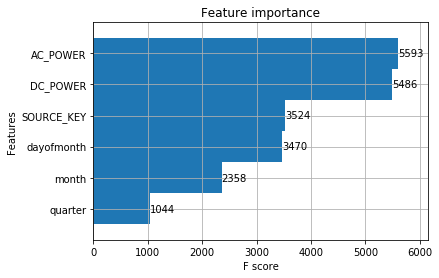

In [15]:
plot_importance(xgbDefined, height=1)

The Mean squared error value reported was very close to zero showing that the model does stay relative close to the actual value. That leaves me optomistic from the intial test set xgboost model above. 

In [45]:
y_pred = reg.predict(X_test)
mean_squared_error(y_test,y_pred)                                                                               

503.01312952905687

## Prediction model for unknown events 

For the Prediction model of unknown events: 
- Ive set the days(d) to 1 to predict one day into the future. 
- Setup up a new data frame set of setup_df to read in the variables from the power generation set
- Populated the forecast data set with the parameters from powerGeneration
- Populated the data with quarter, month, year, day of month data to the set

From here Ive encoded the forecast source key once again for the forecast set, so the panels still correspond with each other.
Set the y_ predict to what the XGB algo could predict given the new daily information of the forecast data for the day in the future.
Then append the forecast dy_predict value equal to the predicted yield of the xgb forecast
Then print out the forecast results

From here I would then be able to produce whether or not weather was affecting the panels that day, but i was unable to as mentioned in the video 

In [16]:
#
d = 1
forecast = pd.DataFrame()
for i in range(0,d):
        setup_df = pd.DataFrame()
        setup_df["DATE_TIME"] =  powerGeneration["DATE_TIME"]
        setup_df["SOURCE_KEY"] = powerGeneration["SOURCE_KEY"]
        setup_df["DC_POWER"] = powerGeneration['DC_POWER']
        setup_df["AC_POWER"] = powerGeneration["AC_POWER"]
        forecast = forecast.append(setup_df)
forecast['DATE_TIME']= pd.to_datetime(forecast['DATE_TIME']) 
forecast.index = forecast.DATE_TIME.dt.date.astype("datetime64[ns]")
forecast = forecast.drop(["DATE_TIME"],axis=1)
    # stint of code from above to merge datasets 
forecast['quarter'] = forecast.index.quarter
forecast['month'] = forecast.index.month
forecast['year'] = forecast.index.year
forecast['dayofmonth'] = forecast.index.day
forecast['dayofyear'] = forecast.index.dayofyear

In [17]:
#return UnknownPredict

forecast['SOURCE_KEY'] = label_encoder.fit_transform(forecast['SOURCE_KEY'])
y_predict = xgbDefined.predict(forecast)
forecast['DY_Predict'] = y_predict

ValueError: feature_names mismatch: ['SOURCE_KEY', 'quarter', 'month', 'year', 'dayofmonth', 'DC_POWER', 'AC_POWER'] ['SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'quarter', 'month', 'year', 'dayofmonth', 'dayofyear']
training data did not have the following fields: dayofyear

In [18]:
forecast

,SOURCE_KEY,DC_POWER,AC_POWER,quarter,month,year,dayofmonth,dayofyear
DATE_TIME,,,,,,,,
1970-01-01,0,0.0,0.0,1,1,1970,1,1
1970-01-01,1,0.0,0.0,1,1,1970,1,1
1970-01-01,2,0.0,0.0,1,1,1970,1,1
1970-01-01,3,0.0,0.0,1,1,1970,1,1
1970-01-01,4,0.0,0.0,1,1,1970,1,1
...,...,...,...,...,...,...,...,...
1970-01-01,17,0.0,0.0,1,1,1970,1,1
1970-01-01,18,0.0,0.0,1,1,1970,1,1
1970-01-01,19,0.0,0.0,1,1,1970,1,1
